![](https://www.pata.org/wp-content/uploads/2014/09/TripAdvisor_Logo-300x119.png)
# Predict TripAdvisor Rating
## В этом соревновании нам предстоит предсказать рейтинг ресторана в TripAdvisor
**По ходу задачи:**
* Прокачаем работу с pandas
* Научимся работать с Kaggle Notebooks
* Поймем как делать предобработку различных данных
* Научимся работать с пропущенными данными (Nan)
* Познакомимся с различными видами кодирования признаков
* Немного попробуем [Feature Engineering](https://ru.wikipedia.org/wiki/Конструирование_признаков) (генерировать новые признаки)
* И совсем немного затронем ML
* И многое другое...   



### И самое важное, все это вы сможете сделать самостоятельно!

*Этот Ноутбук являетсся Примером/Шаблоном к этому соревнованию (Baseline) и не служит готовым решением!*   
Вы можете использовать его как основу для построения своего решения.

> что такое baseline решение, зачем оно нужно и почему предоставлять baseline к соревнованию стало важным стандартом на kaggle и других площадках.   
**baseline** создается больше как шаблон, где можно посмотреть как происходит обращение с входящими данными и что нужно получить на выходе. При этом МЛ начинка может быть достаточно простой, просто для примера. Это помогает быстрее приступить к самому МЛ, а не тратить ценное время на чисто инженерные задачи. 
Также baseline являеться хорошей опорной точкой по метрике. Если твое решение хуже baseline - ты явно делаешь что-то не то и стоит попробовать другой путь) 

В контексте нашего соревнования baseline идет с небольшими примерами того, что можно делать с данными, и с инструкцией, что делать дальше, чтобы улучшить результат.  Вообще готовым решением это сложно назвать, так как используются всего 2 самых простых признака (а остальные исключаются).

# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
from datetime import datetime
import re

In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [4]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# DATA

In [5]:
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [7]:
df_train.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [9]:
df_test.head(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [10]:
sample_submission.head(5)

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [11]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [12]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [14]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
38982,id_777,Krakow,NaN,778.0,NaN,2.0,"[['Coffee with a soul)', 'Tasty coffee, cozy p...",/Restaurant_Review-g274772-d10245518-Reviews-D...,d10245518,1,5.0
10704,id_14,Helsinki,"['Cafe', 'European', 'Soups', 'Scandinavian', ...",15.0,$$ - $$$,1488.0,"[['Pretty restaurant and cafeteria', 'Good foo...",/Restaurant_Review-g189934-d850178-Reviews-Kap...,d850178,1,4.0
5243,id_5243,Edinburgh,"['Bar', 'Pub']",1310.0,$$ - $$$,9.0,"[['Good Tiki Themed Bar', 'Christmas day out']...",/Restaurant_Review-g186525-d12455636-Reviews-T...,d12455636,0,0.0
18185,id_3,Madrid,"['International', 'Mediterranean', 'European',...",4.0,$$ - $$$,302.0,"[['Small place with big flavours', 'The best d...",/Restaurant_Review-g187514-d11896546-Reviews-A...,d11896546,1,5.0
7527,id_7527,Paris,['French'],5938.0,$$ - $$$,124.0,"[['Nice place for brunch', 'so so'], ['02/27/2...",/Restaurant_Review-g187147-d3393209-Reviews-Au...,d3393209,0,0.0


Как видим, большинство признаков у нас требует очистки и предварительной обработки.

# Cleaning and Prepping Data
Обычно данные содержат в себе кучу мусора, который необходимо почистить, для того чтобы привести их в приемлемый формат. Чистка данных — это необходимый этап решения почти любой реальной задачи.   
![](https://analyticsindiamag.com/wp-content/uploads/2018/01/data-cleaning.png)

 # Restaurant_id

Посмотрим на параметр "Restaurant_id". Данные представляют собой строковые значения, пропусков нет. Проверим, все ли значения уникальны.

In [15]:
data['Restaurant_id'].nunique(dropna=False)

13094

In [16]:
data['Restaurant_id'].value_counts()

id_227      19
id_436      19
id_871      19
id_633      19
id_430      18
            ..
id_13350     1
id_13723     1
id_8848      1
id_6577      1
id_9313      1
Name: Restaurant_id, Length: 13094, dtype: int64

In [17]:
data.groupby('Restaurant_id')['Rating'].agg('mean')

Restaurant_id
id_0       4.625000
id_1       4.150000
id_10      4.166667
id_100     4.000000
id_1000    3.833333
             ...   
id_9995    2.500000
id_9996    0.000000
id_9997    0.000000
id_9998    0.000000
id_9999    0.000000
Name: Rating, Length: 13094, dtype: float64

Создадим новый признак, в который передадим Restaurant_id в числовом формате. Одновременно создадим список, в который будем сохранять признаки, которые не понадобятся на этапе ML.


In [18]:
drop_list = list()

In [19]:
data['Restaurant_id_num'] = data['Restaurant_id'].apply(lambda x: int(x[3::]))
drop_list.append('Restaurant_id')

In [20]:
data[['Restaurant_id_num', 'Rating']].corr()

,Restaurant_id_num,Rating
Restaurant_id_num,1.000000,-0.257137
Rating,-0.257137,1.000000


Как видно из корреляционного анализа, есть заметная обратная зависимость рейтинга от id ресторана.

# City

In [21]:
data['City'].nunique(dropna=False)

31

В этом столбце также нет пропусков, и всего 31 уникальное значение. Эти данные можно будет использовать для создание дополнительных признаков. Для начала создадим dummy-переменные. Чтобы не потерять оригинальный столбец, который планируется использовать для генерации других признаков, dummy-переменные создаем на основании дублираованного столбца.

In [22]:
data['City_code'] = data['City']
data = pd.get_dummies(data, columns=[ 'City_code',], dummy_na=True)

Среди городов есть столицы. Создадим столбец, указывающий на этот признак.

In [23]:
capitals = ['Athens', 'Berlin', 'Bratislava', 'Brussels', 'Budapest', 'Copenhagen', 'Dublin', 'Helsinki',
            'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Madrid', 'Oslo', 'Paris', 'Rome', 'Stockholm',
            'Vienna', 'Warsaw','Zurich']    
data['is_capital'] = data['City'].apply(lambda x: 1 if x in capitals else 0)

In [24]:
data['is_capital'].value_counts()

1    34735
0    15265
Name: is_capital, dtype: int64

Также встречаются города из одной страны. Создадим новый признак "Country" и сгенерируем на его основе dummy-переменные. Этот признак создадим только для тех стран, которые представлены несколькими странами, так как в противном случае этот признак будет дублирующим для определенных городов.

In [25]:
def country(row):
    if row['City'] in ['Berlin', 'Hamburg', 'Munich']:
        return 'Germany'
    elif row['City'] in ['Geneva', 'Zurich']:
        return 'Switzerland' 
    elif row['City'] in ['Krakow', 'Prague', 'Warsaw']:
        return 'Poland'
    elif row['City'] in ['Lisbon', 'Oporto']:
        return 'Portugal'
    elif row['City'] in ['Lyon', 'Paris']:
        return 'France'
    elif row['City'] in ['Milan', 'Rome']:
        return 'Italy'
    else:
        return None
    
data['Country'] = data.apply(country, axis=1)
data = pd.get_dummies(data, columns=['Country'], dummy_na=True)
data.drop(['Country_nan'], axis=1, inplace=True)

Также можно добавить признак с населением грода. Для этого загрузим дополнительные данные.

In [28]:
city_pop = pd.read_excel('PopulatinandArea.csv')

In [29]:
city_pop.head()

,CityNo,City,Country,Population,Area in km2
0,1,Amsterdam,Netherland,851573,219.32
1,2,Athens,Greece,664046,2929.00
2,4,Barcelona,Spain,1620809,101.40
3,4,Berlin,Germany,3711930,891.70
4,5,Bratislava,Slovakia,424428,367.60


In [30]:
city_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CityNo        31 non-null     int64  
 1   City          31 non-null     object 
 2   Country       31 non-null     object 
 3   Population    31 non-null     int64  
 4   Area in km2   31 non-null     float64
dtypes: float64(1), int64(2), object(2)
memory usage: 1.3+ KB


In [31]:
def population(row):
    return int(city_pop[city_pop['City'] == row['City']]['Population'])

data['Population'] = data.apply(population, axis=1)

In [32]:
# Хотя при создании этого столбца не возникло ошибок, убедимся на всякий случай, что население для каждого города было успешно найдено.
data['Population'].isna().sum()

0

In [33]:
data[['Rating', 'Population']].corr()

,Rating,Population
Rating,1.00000,-0.00514
Population,-0.00514,1.00000


Так же в датасете есть данные о площоди города. Добавим признак 'Population_density'.

In [34]:
city_pop.columns.to_list()

['CityNo', 'City', 'Country', 'Population', 'Area in km2 ']

In [35]:
def pop_density(row):
    pop = row['Population']
    area = city_pop[city_pop['City'] == row['City']]['Area in km2 '].values[0]
    return pop/area

data['Population_density'] = data.apply(pop_density, axis=1)

In [36]:
data['Population_density']

0        20934.421252
1         3423.821138
2         1825.776515
3        14538.714992
4         1154.591948
             ...     
49995     7537.819102
49996    20934.421252
49997     5064.138298
49998     3413.181818
49999     7537.819102
Name: Population_density, Length: 50000, dtype: float64

In [37]:
data[['Rating', 'Population', 'Population_density']].corr()

,Rating,Population,Population_density
Rating,1.00000,-0.005140,-0.018270
Population,-0.00514,1.000000,0.376039
Population_density,-0.01827,0.376039,1.000000


Также, используя таблицу city_pop, удобно создать столбец с странами для каждого города.

In [38]:
def country(row):
    return city_pop[city_pop['City'] == row['City']]['Country'].values[0]

data['Country'] = data.apply(country, axis=1)


In [39]:
drop_list.append('Country')

Используя другой датасет, сгенерируем новые признаки 'Happiness' и 'GDP_perCapita', исходя из стран. В результате предварительного анализа, выяснилось, что 'Beer_perCapita', 'Spirit_perCapita', 'Wine_perCapita' дублируют 'GDP_perCapita', поэтому их не испоьзовали.

In [40]:
Happiness_alcohol = pd.read_csv('HappinessAlcoholConsumption.csv')
Happiness_alcohol.head()

,Country,Region,Hemisphere,HappinessScore,HDI,GDP_PerCapita,Beer_PerCapita,Spirit_PerCapita,Wine_PerCapita
0,Denmark,Western Europe,north,7.526,928,53.579,224,81,278
1,Switzerland,Western Europe,north,7.509,943,79.866,185,100,280
2,Iceland,Western Europe,north,7.501,933,60.530,233,61,78
3,Norway,Western Europe,north,7.498,951,70.890,169,71,129
4,Finland,Western Europe,north,7.413,918,43.433,263,133,97


In [41]:
Happiness_alcohol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Country           122 non-null    object 
 1   Region            122 non-null    object 
 2   Hemisphere        122 non-null    object 
 3   HappinessScore    122 non-null    float64
 4   HDI               122 non-null    int64  
 5   GDP_PerCapita     122 non-null    float64
 6   Beer_PerCapita    122 non-null    int64  
 7   Spirit_PerCapita  122 non-null    int64  
 8   Wine_PerCapita    122 non-null    int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 8.7+ KB


In [42]:
Happiness_alcohol['Country'].to_list()

['Denmark',
 'Switzerland',
 'Iceland',
 'Norway',
 'Finland',
 'Canada',
 'Netherlands',
 'New Zealand',
 'Australia',
 'Sweden',
 'Israel',
 'Austria',
 'United States',
 'Costa Rica',
 'Germany',
 'Brazil',
 'Belgium',
 'Ireland',
 'Luxembourg',
 'Mexico',
 'Singapore',
 'United Kingdom',
 'Chile',
 'Panama',
 'Argentina',
 'Czech Republic',
 'United Arab Emirates',
 'Uruguay',
 'Malta',
 'Colombia',
 'France',
 'Thailand',
 'Qatar',
 'Spain',
 'Guatemala',
 'Suriname',
 'Bahrain',
 'Trinidad and Tobago',
 'Venezuela',
 'Slovakia',
 'El Salvador',
 'Nicaragua',
 'Uzbekistan',
 'Italy',
 'Ecuador',
 'Belize',
 'Japan',
 'Kazakhstan',
 'Moldova',
 'Russian Federation',
 'Poland',
 'South Korea',
 'Bolivia',
 'Lithuania',
 'Belarus',
 'Slovenia',
 'Peru',
 'Turkmenistan',
 'Mauritius',
 'Latvia',
 'Cyprus',
 'Paraguay',
 'Romania',
 'Estonia',
 'Jamaica',
 'Croatia',
 'Turkey',
 'Jordan',
 'Azerbaijan',
 'Philippines',
 'China',
 'Kyrgyzstan',
 'Serbia',
 'Bosnia and Herzegovina',
 'Mo

In [43]:
# В датасете не совпадали названия нескольких стран, а именно для Чехии и Нидерландов, также не было данных для Англии и Шотландии по отдельности. 
# Это пришлось учесть при написании функции.
def happiness(row):
    if row['Country'] in ['England', 'Scotland']:
        return Happiness_alcohol[Happiness_alcohol['Country'] == 'United Kingdom']['HappinessScore'].values[0]
    if row['Country'] == 'Netherland':
        return Happiness_alcohol[Happiness_alcohol['Country'] == 'Netherlands']['HappinessScore'].values[0]
    if row['Country'] == 'Czech':
        return Happiness_alcohol[Happiness_alcohol['Country'] == 'Czech Republic']['HappinessScore'].values[0]
    return Happiness_alcohol[Happiness_alcohol['Country'] == row['Country']]['HappinessScore'].values[0]

data['Happiness'] = data.apply(happiness, axis=1)

In [44]:
def GDP(row):
    if row['Country'] in ['England', 'Scotland']:
        return Happiness_alcohol[Happiness_alcohol['Country'] == 'United Kingdom']['GDP_PerCapita'].values[0]
    if row['Country'] == 'Netherland':
        return Happiness_alcohol[Happiness_alcohol['Country'] == 'Netherlands']['GDP_PerCapita'].values[0]
    if row['Country'] == 'Czech':
        return Happiness_alcohol[Happiness_alcohol['Country'] == 'Czech Republic']['GDP_PerCapita'].values[0]
    return Happiness_alcohol[Happiness_alcohol['Country'] == row['Country']]['GDP_PerCapita'].values[0]

data['GDP_PerCapita'] = data.apply(GDP, axis=1)

In [45]:
import math

In [46]:
drop_list.append('City')
drop_list.append('City_code_nan')

# Cuisine Style

In [47]:
data['Cuisine Style'].isna().sum()

11590

Обработаем данные из столбца "Cuisine Style".
Данные представляют собой строковые значения, которые выглядят как список из нескольких видов кухни, а также содержат пустые значения.
Обработаем признак с помощью метода One-Hot encoding, а также создадим список всех видов кухни, который будем использовать для кодировки. 

Кроме того, создадим еще признак о количестве видов кухни.

In [48]:
Cuisine_list = set()

for styles in data['Cuisine Style']:
    if pd.isna(styles):
        continue    
    else:
        styles = styles[1:-1].split(', ')
        for style in styles:
            Cuisine_list.add(style[1:-1])

# Здесь невозможно использовать функцию get_dummies, так как необходимо выделять виды кухни из строкового значения            
def find_item(cell):
    if item in str(cell):
        return 1
    else:
        return 0

for style in Cuisine_list:
    item = style
    name = 'Cuisine_{}'.format(item)
    data[name] = data['Cuisine Style'].apply(find_item)
    

# Tак как здесь не использовалать функция get_dummies, необходимо дополнительно прописать функцию, для создания dummy-переменной в случае значения None
def fill_cuisine_nan(row):
    if pd.isna(row['Cuisine Style']):
        return 1
    else:
        return 0
    
data['Cuisine_nan'] = data.apply(fill_cuisine_nan, axis=1)

In [49]:
Cuisine_list

{'Afghani',
 'African',
 'Albanian',
 'American',
 'Arabic',
 'Argentinean',
 'Armenian',
 'Asian',
 'Australian',
 'Austrian',
 'Azerbaijani',
 'Balti',
 'Bangladeshi',
 'Bar',
 'Barbecue',
 'Belgian',
 'Brazilian',
 'Brew Pub',
 'British',
 'Burmese',
 'Cafe',
 'Cajun & Creole',
 'Cambodian',
 'Canadian',
 'Caribbean',
 'Caucasian',
 'Central American',
 'Central Asian',
 'Central European',
 'Chilean',
 'Chinese',
 'Colombian',
 'Contemporary',
 'Croatian',
 'Cuban',
 'Czech',
 'Danish',
 'Delicatessen',
 'Diner',
 'Dutch',
 'Eastern European',
 'Ecuadorean',
 'Egyptian',
 'Ethiopian',
 'European',
 'Fast Food',
 'Filipino',
 'French',
 'Fujian',
 'Fusion',
 'Gastropub',
 'Georgian',
 'German',
 'Gluten Free Options',
 'Greek',
 'Grill',
 'Halal',
 'Hawaiian',
 'Healthy',
 'Hungarian',
 'Indian',
 'Indonesian',
 'International',
 'Irish',
 'Israeli',
 'Italian',
 'Jamaican',
 'Japanese',
 'Korean',
 'Kosher',
 'Latin',
 'Latvian',
 'Lebanese',
 'Malaysian',
 'Mediterranean',
 'Mexic

In [50]:
def variety(row):
    if pd.isna(row['Cuisine Style']):
        return 0    
    return len(row['Cuisine Style'].split(', '))
        
data['Cuisine_variety'] = data.apply(variety, axis=1)

Сгенерируем признак, в который запишем инфомацию, подается ли в ресторане национальная кухня.

In [51]:
National_cuisine = {'France': 'French', 'England': 'British', 'Spain': 'Spanish', 'Italy': 'Italian', 'Germany': 'German', 'Portugal': 'Portuguese',
                    'Czech': 'Czech', 'Poland': 'Polish', 'Austria': 'Austrian', 'Netherland': 'Dutch', 'Belgium': 'Belgian', 'Switzerland': 'Swiss', 
                    'Sweden': 'Swedish', 'Hungary': 'Hungarian', 'Ireland': 'Irish', 'Denmark': 'Danish', 'Greece': 'Greek', 'Scotland': 'Scottish',
                    'Norway': 'Norwegian', 'Finland': 'Finnish', 'Slovakia': 'Slovak', 'Luxembourg': 'Luximbourgish', 'Slovenia': 'Slovenian'}


In [52]:
National_cuisine = {'France': 'French', 'England': 'British', 'Spain': 'Spanish', 'Italy': 'Italian', 'Germany': 'German', 'Portugal': 'Portuguese',
                    'Czech': 'Czech', 'Poland': 'Polish', 'Austria': 'Austrian', 'Netherland': 'Dutch', 'Belgium': 'Belgian', 'Switzerland': 'Swiss', 
                    'Sweden': 'Swedish', 'Hungary': 'Hungarian', 'Ireland': 'Irish', 'Denmark': 'Danish', 'Greece': 'Greek', 'Scotland': 'Scottish',
                    'Norway': 'Norwegian', 'Finland': 'Finnish', 'Slovakia': 'Slovak', 'Luxembourg': 'Luximbourgish', 'Slovenia': 'Slovenian'}

def national_cuisine(row):
    if pd.isna(row["Cuisine Style"]):
        return 0
    for value, key in National_cuisine.items():
        if value == row['Country']:
            if key in row['Cuisine Style']:
                return 1
    return 0
data['National_cuisine'] = data.apply(national_cuisine, axis=1)

In [53]:
data['National_cuisine'].value_counts()

0    33563
1    16437
Name: National_cuisine, dtype: int64

In [54]:
data[['Rating', 'National_cuisine']].corr()

,Rating,National_cuisine
Rating,1.000000,0.012573
National_cuisine,0.012573,1.000000


In [55]:
drop_list.append('Cuisine Style')

# Ranking

В этом столбце нет пропусков. Посмотрим как изменяется Ranking по городам, а также проверим, есть ли связь между Ranking и id ресторана.

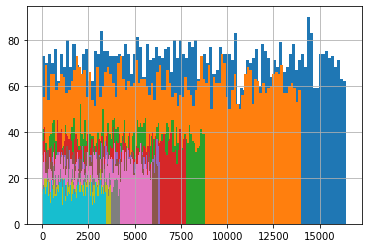

In [56]:
# Построим график для десяти городов с найбольшим количеством ресторанов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Из-за того, что количество ресторанов в городах разное, масимальное значение Ranking для рестоанов будет разным в разных городах. Необходимо отнормировать этот признак, относитльно города.

In [57]:
ranking_mean = data.groupby('City')['Ranking'].agg('mean')
rest_num = data['City'].value_counts()

In [58]:
def norm(row):
    return (row['Ranking']-ranking_mean[row['City']])/rest_num[row['City']]

data['Ranking_norm'] = data.apply(norm, axis=1)

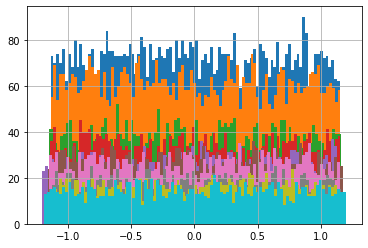

In [59]:
# Построим на график после нормирования
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking_norm'][data['City'] == x].hist(bins=100)
plt.show()

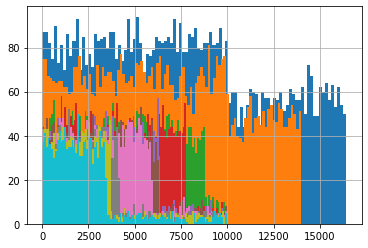

In [60]:
for x in (data['City'].value_counts())[0:10].index:
    data['Restaurant_id_num'][data['City'] == x].hist(bins=100)
plt.show()

Распределение 'Restaurant_id' тожу чувствительно к количеству ресторанов в городе. Нормируем и это значение.

In [61]:
id_mean = data.groupby('City')['Restaurant_id_num'].agg('mean')

def id_norm(row):
    return (row['Restaurant_id_num']-id_mean[row['City']])/rest_num[row['City']]

data['Restaurant_id_norm'] = data.apply(id_norm, axis=1)

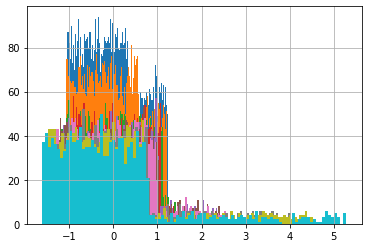

In [62]:
for x in (data['City'].value_counts())[0:10].index:
    data['Restaurant_id_norm'][data['City'] == x].hist(bins=100)
plt.show()

In [63]:
data[['Ranking', 'Ranking_norm', 'Restaurant_id_num', 'Restaurant_id_norm', 'Rating']].corr()

,Ranking,Ranking_norm,Restaurant_id_num,Restaurant_id_norm,Rating
Ranking,1.000000,0.568802,0.825090,0.161177,-0.109897
Ranking_norm,0.568802,1.000000,0.467784,0.280428,-0.169041
Restaurant_id_num,0.825090,0.467784,1.000000,0.508776,-0.257137
Restaurant_id_norm,0.161177,0.280428,0.508776,1.000000,-0.450270
Rating,-0.109897,-0.169041,-0.257137,-0.450270,1.000000


Так, с помощью нормирования удалось усилить корреляцию значений Ranking и Restaurant_id с рейтингом.

In [64]:
drop_list.append('Ranking')
drop_list.append('Restaurant_id_num')

# Price Range

In [65]:
data['Price Range'].value_counts()

$$ - $$$    23041
$            7816
$$$$         1782
Name: Price Range, dtype: int64

In [66]:
data['Price Range'].isna().sum()

17361

В данном столбце много пропусков (~35%). Трансформируем значения в числа для упрощения работы.

In [67]:
# 3:$$$$
# 2:$$ - $$$
# 1: $
# 0: NaN
def fill_price_r(row):
    if row['Price Range'] == '$$$$':
        return 3
    if row['Price Range'] == '$$ - $$$':
        return 2
    if row['Price Range'] == '$':
        return 1
    return None
    
data['Price Range'] = data.apply(fill_price_r, axis=1)

In [68]:
data['Price Range'].median()

2.0

Заполним пропуски медианным значением. Но перед этим сохраним информацию о пропусках в отдельном столбце.

In [69]:
data['no_price_data'] = data['Price Range'].apply(lambda x: 1 if pd.isna(x) else 0)

In [70]:
data['no_price_data'].value_counts()

0    32639
1    17361
Name: no_price_data, dtype: int64

In [71]:
data['Price Range'].fillna(data['Price Range'].median(), inplace=True)

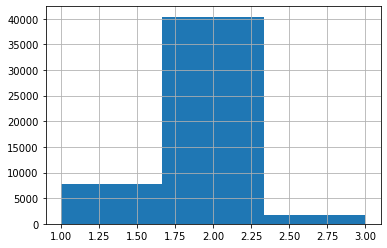

In [72]:
data['Price Range'].hist(bins=3)

# Number of Reviews

In [73]:
data['Number of Reviews'].isna().sum()

3200

Здесь также присутствуют пропуски. Прежде, чем их заменить, также сохраним информацию о них в отдельном столбце.

In [74]:
data['no_data_Number_of_Reviews'] = pd.isna(data['Number of Reviews']).astype('uint8')

In [75]:
data['no_data_Number_of_Reviews'].value_counts()

0    46800
1     3200
Name: no_data_Number_of_Reviews, dtype: int64

Посмотрим, как распределен признак.

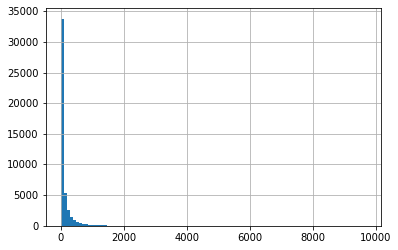

In [76]:
data['Number of Reviews'].hist(bins=100)

Видно, что в большинстве случаев количество отзывов не превышает 100. Посмотрим на гистограмму в этом диапазоне.

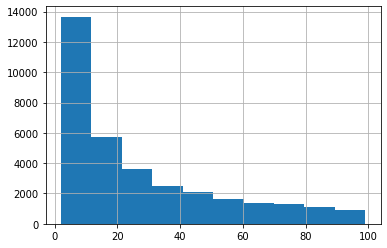

In [77]:
data[data['Number of Reviews']<100]['Number of Reviews'].hist()

In [78]:
def fill_num_rev(row):
    if pd.isna(row['Number of Reviews']):
        return data[data['City'] == row['City']]['Number of Reviews'].median()
    return row['Number of Reviews']
    
data['Number of Reviews_filled'] = data.apply(fill_num_rev, axis=1)

In [79]:
data[['Number of Reviews', 'Number of Reviews_filled', 'Population', 'Ranking_norm', 'Population_density']].corr()

,Number of Reviews,Number of Reviews_filled,Population,Ranking_norm,Population_density
Number of Reviews,1.000000,1.000000,2.197249e-02,-3.995422e-01,-5.291924e-03
Number of Reviews_filled,1.000000,1.000000,2.222946e-02,-4.008490e-01,-2.042913e-03
Population,0.021972,0.022229,1.000000e+00,-1.071592e-17,3.760393e-01
Ranking_norm,-0.399542,-0.400849,-1.071592e-17,1.000000e+00,-2.571876e-18
Population_density,-0.005292,-0.002043,3.760393e-01,-2.571876e-18,1.000000e+00


In [80]:
data[['Number of Reviews', 'Number of Reviews_filled', 'Rating']].corr()

,Number of Reviews,Number of Reviews_filled,Rating
Number of Reviews,1.000000,1.000000,0.011472
Number of Reviews_filled,1.000000,1.000000,0.011235
Rating,0.011472,0.011235,1.000000


In [81]:
data.groupby('City')['Number of Reviews'].agg(['mean', 'median'])

,mean,median
City,,
Amsterdam,148.744436,46.0
Athens,93.987517,22.0
Barcelona,135.683096,35.0
Berlin,63.772188,17.0
Bratislava,51.616099,10.0
Brussels,92.647154,28.0
Budapest,158.680214,24.0
Copenhagen,95.058065,33.0
Dublin,154.276382,44.0


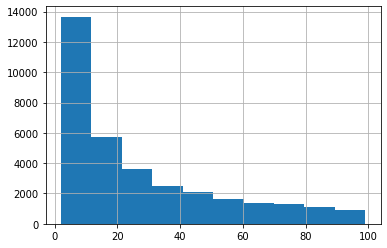

In [82]:
data[data['Number of Reviews']<100]['Number of Reviews'].hist()

Заполнить пропуски каким-то конкретным значением на мой взгляд не будет корректным. Сгенерируем новый признак, который характеризовал бы середину диапазона, в который попадает то или иное значение количества отзывов. Для этого каждое значение разделим на 50 и округлим до целого.

In [83]:
data['Number of Reviews_50'] = data['Number of Reviews'].apply(lambda x: None if pd.isna(x) else round(x/50, 0))

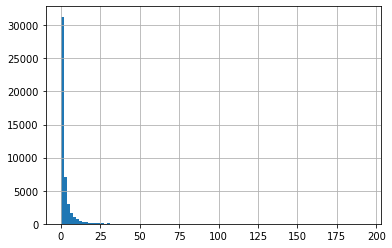

In [84]:
data['Number of Reviews_50'].hist(bins=100)

Проверим, сможем ли мы заполнять пропуски медианным значением в зависимости от города.

In [85]:
data.groupby('City')['Number of Reviews_50'].agg(['mean', 'median'])

,mean,median
City,,
Amsterdam,2.934766,1.0
Athens,1.815534,0.0
Barcelona,2.658136,1.0
Berlin,1.191411,0.0
Bratislava,0.938080,0.0
Brussels,1.783740,1.0
Budapest,3.099465,0.0
Copenhagen,1.842581,1.0
Dublin,3.040201,1.0


In [86]:
def fill_num_rev(row):
    if pd.isna(row['Number of Reviews_50']):
        return data[data['City'] == row['City']]['Number of Reviews_50'].min()
    return row['Number of Reviews_50']

data['Number of Reviews_50_min'] = data.apply(fill_num_rev, axis=1)

In [87]:
data['Number of Reviews_50_min'].value_counts()

0.0      24230
1.0      10253
2.0       4511
3.0       2608
4.0       1722
         ...  
126.0        1
65.0         1
94.0         1
179.0        1
120.0        1
Name: Number of Reviews_50_min, Length: 102, dtype: int64

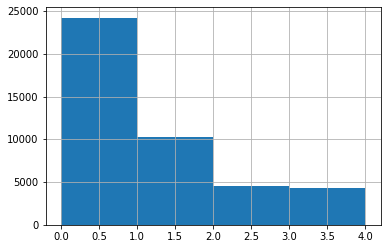

In [88]:
data[data['Number of Reviews_50_min'] < 5]['Number of Reviews_50_min'].hist(bins=4)

Проверим, не потеряли ли мы коррелецию в результате проведенных манипуляций.

In [89]:
data[['Number of Reviews', 'Number of Reviews_50','Number of Reviews_50_min', 'Rating']].corr()

,Number of Reviews,Number of Reviews_50,Number of Reviews_50_min,Rating
Number of Reviews,1.000000,0.999015,0.999015,0.011472
Number of Reviews_50,0.999015,1.000000,1.000000,0.010985
Number of Reviews_50_min,0.999015,1.000000,1.000000,0.010543
Rating,0.011472,0.010985,0.010543,1.000000


In [90]:
drop_list.append('Number of Reviews')
drop_list.append('Number of Reviews_50')

# Reviews

In [91]:
data['Reviews'].isna().sum()

2

На первый взглд здесь всего лишь 2 пропуска, но если просмотреть значения, то можно заметить довольно много значений вида '[[],[]]', что также можно рассматривать как пустые значения. В среднем структура значений представляеи собой список из двух вложенных списков: текст отзыва и дата отзыва. Проверим, сколько отзывов модет быть вложено.

In [92]:
data['Reviews_num'] = data['Reviews'].apply(lambda x: 0 if str(x) == '[[], []]' else len(str(x).split('], [')[0].split("', '")))
data['Reviews_num'].fillna(0, inplace=True)
data['Reviews_num'].value_counts()

2    34787
0     8112
1     7101
Name: Reviews_num, dtype: int64

Далее извлечем даты в отдельные столбцы, а также посчитаем время между двумя отзывами и как давно был сделан последний отзыв.

In [93]:
def find_date(string):
    pattern = re.compile('\d\d\/\d\d\/\d\d\d\d')
    return pattern.findall(string)


def date_1(row):
    if pd.isna(row['Reviews']):
        return None
    date_list = find_date(row['Reviews'])
    if len(date_list) == 0:
        return None
    else:
        date_1 = datetime.strptime(date_list[0], '%m/%d/%Y')
        if len(date_list) > 1:
            date_2 = datetime.strptime(date_list[1], '%m/%d/%Y')
            if date_1 > date_2:
                return date_1
            else:
                return date_2
        return date_1


def date_2(row):
    if pd.isna(row['Reviews']):
        return None
    date_list = find_date(row['Reviews'])
    if len(date_list) in [0, 1]:
        return None
    else:
        date_1 = datetime.strptime(date_list[0], '%m/%d/%Y')
        date_2 = datetime.strptime(date_list[1], '%m/%d/%Y')
        if date_1 > date_2:
            return date_2
        else:
            return date_1


data['last_date_1'] = data.apply(date_1, axis=1)
data['last_date_2'] = data.apply(date_2, axis=1)

In [94]:
# Новые столбец с количеством дней между отзывами
def days_btw(row):
    if pd.isna(row['last_date_2']):
        return None
    return (row['last_date_1']-row['last_date_2']).days


data['days_btw_rev'] = data.apply(days_btw, axis=1)

In [95]:
data['days_btw_rev'].isna().sum()

13794

Тут получилось довольно много пропусков. Посмотрим на распределение признака.

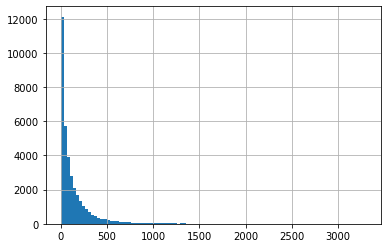

In [96]:
data['days_btw_rev'].hist(bins=100)

Здесь можно наблюдать аналогичную ситуацию, как в случае с количеством отзывов ('Number of Reviews'). Для заполнения пропусков поступим также.

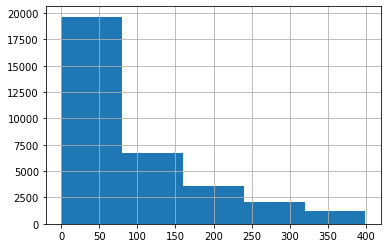

In [97]:
data[data['days_btw_rev']<400]['days_btw_rev'].hist(bins=5)

In [98]:
def fill_days_btw(row):
    if pd.isna(row['days_btw_rev']):
        return data[data['City'] == row['City']]['days_btw_rev'].median()
    return row['days_btw_rev']
data['days_btw_rev_filled'] = data.apply(fill_days_btw, axis=1)

In [99]:
data['days_btw_rev_filled'].isna().sum()

0

In [100]:
# Новый признак, характеризующий диапазон, в который попадает значение 'days_btw_rev'
data['days_btw_rev_100'] = data['days_btw_rev'].apply(lambda x: None if x is None else round(x/100, 0))

In [101]:
# Проверяем, есть ли зависимость от города
data.groupby('City')['days_btw_rev_100'].agg(['mean', 'median'])

,mean,median
City,,
Amsterdam,0.801646,0.0
Athens,1.268781,0.0
Barcelona,1.404557,1.0
Berlin,1.833889,1.0
Bratislava,1.742537,1.0
Brussels,1.620476,1.0
Budapest,1.150898,0.0
Copenhagen,1.082849,1.0
Dublin,0.850822,0.0


In [102]:
# Функция для заполнения пропусков
def fill_days_btw(row):
    if pd.isna(row['days_btw_rev_100']):
        return data[data['City'] == row['City']]['days_btw_rev_100'].median()
    return row['days_btw_rev_100']

data['days_btw_rev_100'] = data.apply(fill_days_btw, axis=1)

In [103]:
data[['Rating', 'days_btw_rev_filled', 'days_btw_rev_100']].corr()

,Rating,days_btw_rev_filled,days_btw_rev_100
Rating,1.000000,-0.029552,-0.029814
days_btw_rev_filled,-0.029552,1.000000,0.990918
days_btw_rev_100,-0.029814,0.990918,1.000000


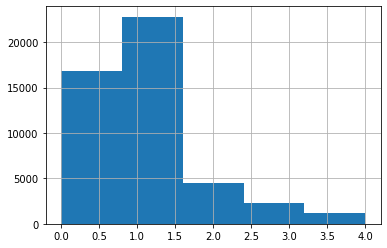

In [104]:
data[data['days_btw_rev_100'] < 5]['days_btw_rev_100'].hist(bins=5)

In [105]:
# Новый признак, характеризующий, как давно был оставлен последний отзыв. В качестве референса возьмем максимальное значение из всех
def days_since(row):
    if pd.isna(row['last_date_1']):
        return None
    else:
        return (data['last_date_1'].max()-row['last_date_1']).days


data['days_since_last_rev'] = data.apply(days_since, axis=1)

In [106]:
# Пропуски
data['days_since_last_rev'].isna().sum()

8114

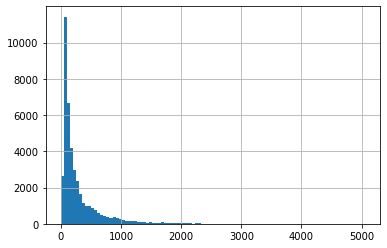

In [107]:
# Посмотрим на распределение признака
data['days_since_last_rev'].hist(bins=100)

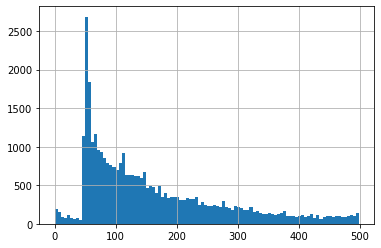

In [108]:
data[data['days_since_last_rev']<500]['days_since_last_rev'].hist(bins=100)

In [109]:
def fill_days_since(row):
    if pd.isna(row['days_since_last_rev']):
        return data[data['City'] == row['City']]['days_since_last_rev'].median()
    return row['days_since_last_rev']
data['days_since_last_rev_filled'] = data.apply(fill_days_since, axis=1)

In [110]:
# Новый признак, характеризующий диапазон, в который попадает значение 'days_since_last_rev'
data['days_since_last_rev_100'] = data['days_since_last_rev'].apply(lambda x: None if x is None else round(x/100, 0))

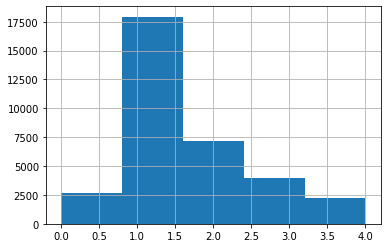

In [111]:
# По гистограмме видно, что вид распределения сохраняется после преобразования
data[data['days_since_last_rev_100']<5]['days_since_last_rev_100'].hist(bins=5)

In [112]:
# Функция для заполнения пропусков
def fill_days_since(row):
    if pd.isna(row['days_since_last_rev_100']):
        return data[data['City'] == row['City']]['days_since_last_rev_100'].median()
    return row['days_since_last_rev_100']

data['days_since_last_rev_100'] = data.apply(fill_days_since, axis=1)

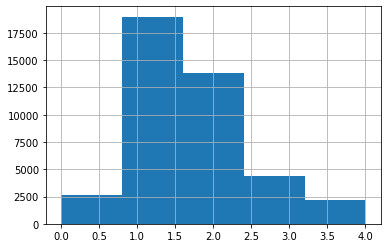

In [113]:
data[data['days_since_last_rev_100']<5]['days_since_last_rev_100'].hist(bins=5)

In [114]:
data[['Rating', 'days_since_last_rev_filled', 'days_since_last_rev_100']].corr()

,Rating,days_since_last_rev_filled,days_since_last_rev_100
Rating,1.000000,-0.028872,-0.028173
days_since_last_rev_filled,-0.028872,1.000000,0.995997
days_since_last_rev_100,-0.028173,0.995997,1.000000


Попробуем определить положительный или негативный характер отзыва по ключевым словам

In [115]:
positive_list = ['good', 'lovely', 'great', 'perfect', 'awesome', 'best', 'excellent', 'pleasent',
                'outstanding', 'exceptional', 'fantastic', 'wonderful', 'fabulous', 'worth'
                'enjoyable', 'nice', 'cosy', 'tasty', 'delicious', 'friendly', 'decent', 'gem',
                'happy']


negative_list = ['bad', 'terrible', 'awful', 'poor', 'unacceptable', 'worst', 'gross',
                 'regret', 'unpleasent', 'unsatisfactory', 'disgusting', 'unfriendly',
                'rude', 'overpriced', 'slow', 'dissapoint', 'inadequate', 'weak', 'worse'
                'unhappy', 'unfortunate']


In [116]:
def positive_rev(row):
    a = str(row['Reviews']).lower().split('], [')[0].split("', '")
    for word in positive_list:
        if len(a) == 2:
            if ((word in a[0]) and not ('not' in a[0])) and (
                (word in a[1]) and not ('not' in a[1])):
                return 5
            elif ((word in a[0]) and not ('not' in a[0])) or (
                (word in a[1]) and not ('not' in a[1])):
                return 4
        elif len(a) == 1:
            if ((word in a[0]) and not ('not' in a[0])):
                return 4
    for word in negative_list:
        if len(a) == 2:
            if ((word in a[0]) and not ('not' in a[0])) and (
                (word in a[1]) and not ('not' in a[1])):
                return 1
            elif ((word in a[0]) and not ('not' in a[0])) or (
                (word in a[1]) and not ('not' in a[1])):
                return 2
        elif len(a) == 1:
            if ((word in a[0]) and not ('not' in a[0])):
                return 2
    return 3

data['Positive_rev'] = data.apply(positive_rev, axis=1)

In [117]:
data['Positive_rev'].value_counts()

4    28397
3    18393
5     2106
2     1081
1       23
Name: Positive_rev, dtype: int64

In [118]:
data[['Rating', 'Positive_rev']].corr()

,Rating,Positive_rev
Rating,1.000000,0.060604
Positive_rev,0.060604,1.000000


In [119]:
drop_list.append('Reviews')
drop_list.append('last_date_1')
drop_list.append('last_date_2')
drop_list.append('days_btw_rev')
drop_list.append('days_since_last_rev')

# ID_TA

In [120]:
data['ID_TA'].isna().sum()

0

In [121]:
data['ID_TA']

0        d10746918
1         d6674944
2        d13129638
3          d680417
4         d1112354
           ...    
49995     d2104414
49996     d1800036
49997      d947615
49998     d1100838
49999     d1109020
Name: ID_TA, Length: 50000, dtype: object

В данном столбце пропусков нет. Можно заметить,что каждое значение выглядит как числовой код с буквой 'd' в начале. Создадим новый признак, куда передадим эти данные в числовом формате.

In [122]:
data['ID_TA_num'] = data['ID_TA'].apply(lambda x: int(x[1::]))

In [123]:
data[['ID_TA_num', 'Rating']].corr()

,ID_TA_num,Rating
ID_TA_num,1.000000,0.049589
Rating,0.049589,1.000000


# URL_TA

In [124]:
data['URL_TA'].isna().sum()

0

In [125]:
data.loc[0,'URL_TA']

'/Restaurant_Review-g187147-d10746918-Reviews-Le_Perchoir-Paris_Ile_de_France.html'

Значения в этом случае имеют несколько числовых последовательностей, начинающихся с 'g' и 'd'. Вторая последовательность дублирует значения в ID_TA. Поэтому выделим в отдельный признак только первую последовательность.

In [126]:
data['URL_TA_num'] = data['URL_TA'].apply(lambda x: int(x.split('-')[1][1::]))

In [127]:
data[['URL_TA_num', 'Rating']].corr()

,URL_TA_num,Rating
URL_TA_num,1.000000,0.003463
Rating,0.003463,1.000000


In [128]:
drop_list.append('URL_TA')

# Посмотрим распределение целевой переменной 'Rating'

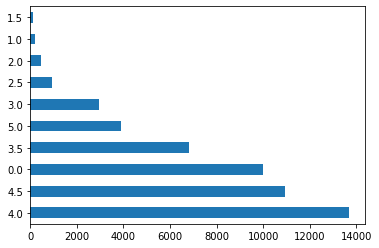

In [129]:
data['Rating'].value_counts().plot(kind='barh')

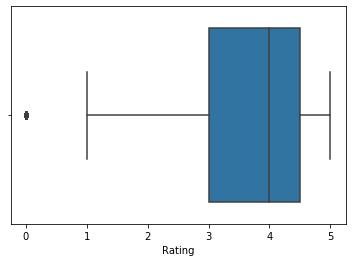

In [130]:
sns.boxplot(x='Rating', data=data)

In [131]:
drop_list.append('Rating')

In [132]:
drop_list

['Restaurant_id',
 'Country',
 'City',
 'City_code_nan',
 'Cuisine Style',
 'Ranking',
 'Restaurant_id_num',
 'Number of Reviews',
 'Number of Reviews_50',
 'Reviews',
 'last_date_1',
 'last_date_2',
 'days_btw_rev',
 'days_since_last_rev',
 'URL_TA',
 'Rating']

### И один из моих любимых - [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике уже сейчас вы сможете заметить, как признаки связаны между собой и с целевой переменной.

In [133]:
data[['Ranking', 'Restaurant_id_num']].corr()

,Ranking,Restaurant_id_num
Ranking,1.00000,0.82509
Restaurant_id_num,0.82509,1.00000


In [134]:
data.groupby('City')['Rating'].agg(['min', 'max', 'mean', 'median'])

,min,max,mean,median
City,,,,
Amsterdam,0.0,5.0,3.270044,4.0
Athens,0.0,5.0,3.423325,4.0
Barcelona,0.0,5.0,3.189985,4.0
Berlin,0.0,5.0,3.285952,4.0
Bratislava,0.0,5.0,3.144737,4.0
Brussels,0.0,5.0,3.153349,4.0
Budapest,0.0,5.0,3.268854,4.0
Copenhagen,0.0,5.0,3.206960,4.0
Dublin,0.0,5.0,3.269737,4.0


In [135]:
data['Rating'].isna().sum()

0

In [136]:
city_rating_mean = data.groupby('City')['Rating'].agg('mean')
city_rating_mean['Berlin']

3.285951940850277

In [137]:
data['City'].value_counts()['Berlin']

2705

In [138]:

def city_rating_mean_norm(row):
    return (row['Rating']-city_rating_mean[row['City']])/data['City'].value_counts()[row['City']]
    
data['city_rating_mean_norm'] = data.apply(city_rating_mean_norm, axis=1)


In [139]:
data[['Rating', 'city_rating_mean_norm']].corr()

,Rating,city_rating_mean_norm
Rating,1.000000,0.719317
city_rating_mean_norm,0.719317,1.000000


In [140]:
data['city_rating_mean_norm']

0       -0.000517
1       -0.006577
2       -0.004390
3       -0.000440
4       -0.008276
           ...   
49995    0.000546
49996    0.000056
49997    0.001382
49998    0.000850
49999   -0.000011
Name: city_rating_mean_norm, Length: 50000, dtype: float64

In [141]:
city_rating_mean = data.groupby('City')['Rating'].agg('mean')
def city_rev_num_mean_norm(row):
    return (row['Number of Reviews_filled']-city_rating_mean[row['City']])/data['City'].value_counts()[row['City']]
    
data['city_rev_num_mean_norm'] = data.apply(city_rev_num_mean_norm, axis=1)

In [142]:
data[['Rating', 'city_rev_num_mean_norm', 'Number of Reviews_filled']].corr()

,Rating,city_rev_num_mean_norm,Number of Reviews_filled
Rating,1.000000,0.007845,0.011235
city_rev_num_mean_norm,0.007845,1.000000,0.716167
Number of Reviews_filled,0.011235,0.716167,1.000000


# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [143]:
# на всякий случай, заново подгружаем данные
df_train = pd.read_csv('main_task.csv')
df_test = pd.read_csv('kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Перебором была определена комбинация тех признаков, которая показывала наилучший результат. Следовательно генерация только этих признаков была включена в следующую функцию.

In [147]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    
    df_output = df_input.copy()
    
    df_output['Number of Reviews_filled_0'] = df_output['Number of Reviews'].fillna(0)
    
    df_output['Restaurant_id_num'] = df_output['Restaurant_id'].apply(lambda x: int(x[3::]))
    print('Restaurant_id')
    df_output['City_code'] = df_output['City']
    df_output = pd.get_dummies(df_output, columns=[ 'City_code',], dummy_na=True)
    
    capitals = ['Athens', 'Berlin', 'Bratislava', 'Brussels', 'Budapest', 'Copenhagen', 'Dublin', 'Helsinki',
            'Lisbon', 'Ljubljana', 'London', 'Luxembourg', 'Madrid', 'Oslo', 'Paris', 'Rome', 'Stockholm',
            'Vienna', 'Warsaw','Zurich']    
    df_output['is_capital'] =  df_output['City'].apply(lambda x: 1 if x in capitals else 0)
    
    def country(row):
        if row['City'] in ['Berlin', 'Hamburg', 'Munich']:
            return 'Germany'
        elif row['City'] in ['Geneva', 'Zurich']:
            return 'Switzerland' 
        elif row['City'] in ['Krakow', 'Prague', 'Warsaw']:
            return 'Poland'
        elif row['City'] in ['Lisbon', 'Oporto']:
            return 'Portugal'
        elif row['City'] in ['Lyon', 'Paris']:
            return 'France'
        elif row['City'] in ['Milan', 'Rome']:
            return 'Italy'
        else:
            return None

    df_output['Country'] = df_output.apply(country, axis=1)
    df_output = pd.get_dummies(df_output, columns=['Country'], dummy_na=True)
    df_output.drop(['Country_nan'], axis=1, inplace=True)
    
    def country(row):
        return city_pop[city_pop['City'] == row['City']]['Country'].values[0]

    df_output['Country'] = df_output.apply(country, axis=1)
    
    Happiness_alcohol = pd.read_csv('HappinessAlcoholConsumption.csv')

    def happiness(row):
        if row['Country'] in ['England', 'Scotland']:
            return Happiness_alcohol[Happiness_alcohol['Country'] == 'United Kingdom']['HappinessScore'].values[0]
        if row['Country'] == 'Netherland':
            return Happiness_alcohol[Happiness_alcohol['Country'] == 'Netherlands']['HappinessScore'].values[0]
        if row['Country'] == 'Czech':
            return Happiness_alcohol[Happiness_alcohol['Country'] == 'Czech Republic']['HappinessScore'].values[0]
        return Happiness_alcohol[Happiness_alcohol['Country'] == row['Country']]['HappinessScore'].values[0]

    df_output['Happiness'] = df_output.apply(happiness, axis=1)
    
    def GDP(row):
        if row['Country'] in ['England', 'Scotland']:
            return Happiness_alcohol[Happiness_alcohol['Country'] == 'United Kingdom']['GDP_PerCapita'].values[0]
        if row['Country'] == 'Netherland':
            return Happiness_alcohol[Happiness_alcohol['Country'] == 'Netherlands']['GDP_PerCapita'].values[0]
        if row['Country'] == 'Czech':
            return Happiness_alcohol[Happiness_alcohol['Country'] == 'Czech Republic']['GDP_PerCapita'].values[0]
        return Happiness_alcohol[Happiness_alcohol['Country'] == row['Country']]['GDP_PerCapita'].values[0]

    df_output['GDP_PerCapita'] = df_output.apply(GDP, axis=1)
    
    
    Cuisine_list = set()

    for styles in df_output['Cuisine Style']:
        if pd.isna(styles):
            continue    
        else:
            styles = styles[1:-1].split(', ')
            for style in styles:
                Cuisine_list.add(style[1:-1])

    def find_item(cell):
        if item in str(cell):
            return 1
        else:
            return 0

    for style in Cuisine_list:
        item = style
        name = 'Cuisine_{}'.format(item)
        df_output[name] =df_output['Cuisine Style'].apply(find_item)

    def fill_cuisine_nan(row):
        if pd.isna(row['Cuisine Style']):
            return 1
        else:
            return 0
    
    df_output['Cuisine_nan'] = df_output.apply(fill_cuisine_nan, axis=1)
    
    def variety(row):
        if pd.isna(row['Cuisine Style']):
            return 0    
        return len(row['Cuisine Style'].split(', '))

    df_output['Cuisine_variety'] = df_output.apply(variety, axis=1)
    
    National_cuisine = {'France': 'French', 'England': 'British', 'Spain': 'Spanish', 'Italy': 'Italian', 'Germany': 'German', 'Portugal': 'Portuguese',
                    'Czech': 'Czech', 'Poland': 'Polish', 'Austria': 'Austrian', 'Netherland': 'Dutch', 'Belgium': 'Belgian', 'Switzerland': 'Swiss', 
                    'Sweden': 'Swedish', 'Hungary': 'Hungarian', 'Ireland': 'Irish', 'Denmark': 'Danish', 'Greece': 'Greek', 'Scotland': 'Scottish',
                    'Norway': 'Norwegian', 'Finland': 'Finnish', 'Slovakia': 'Slovak', 'Luxembourg': 'Luximbourgish', 'Slovenia': 'Slovenian'}

    def national_cuisine(row):
        if pd.isna(row["Cuisine Style"]):
            return 0
        for value, key in National_cuisine.items():
            if value == row['Country']:
                if key in row['Cuisine Style']:
                    return 1
        return 0
    
    df_output['National_cuisine'] = df_output.apply(national_cuisine, axis=1)
    
    ranking_mean = df_output.groupby('City')['Ranking'].agg('mean')
    rest_num = df_output['City'].value_counts()
    
    def norm(row):
        return (row['Ranking']-ranking_mean[row['City']])/rest_num[row['City']]

    df_output['Ranking_norm'] = df_output.apply(norm, axis=1)
    
    df_output['no_price_data'] =  df_output['Price Range'].apply(lambda x: 1 if x is None else 0)
    
    def fill_price_r(row):
        if row['Price Range'] == '$$$$':
            return 3
        if row['Price Range'] == '$$ - $$$':
            return 2
        if row['Price Range'] == '$':
            return 1
        return 2
    
    df_output['Price Range'] = df_output.apply(fill_price_r, axis=1)
    
    df_output['no_data_Number_of_Reviews'] = pd.isna(df_output['Number of Reviews']).astype('uint8')
    
    city_rating_mean = df_output.groupby('City')['Rating'].agg('mean')
    
    def fill_num_rev(row):
        if pd.isna(row['Number of Reviews']):
            return df_output[df_output['City'] == row['City']]['Number of Reviews'].median()
        return row['Number of Reviews']

    df_output['Number of Reviews_filled'] = df_output.apply(fill_num_rev, axis=1)  
    
    df_output['Reviews_num'] = df_output['Reviews'].apply(lambda x: 0 if str(x) == '[[], []]' else len(str(x).split('], [')[0].split("', '")))
    df_output['Reviews_num'].fillna(0, inplace=True)
    
    def find_date(string):
        pattern = re.compile('\d\d\/\d\d\/\d\d\d\d')
        return pattern.findall(string)


    def date_1(row):
        if pd.isna(row['Reviews']):
            return None
        date_list = find_date(row['Reviews'])
        if len(date_list) == 0:
            return None
        else:
            date_1 = datetime.strptime(date_list[0], '%m/%d/%Y')
            if len(date_list) > 1:
                date_2 = datetime.strptime(date_list[1], '%m/%d/%Y')
                if date_1 > date_2:
                    return date_1
                else:
                    return date_2
            return date_1


    def date_2(row):
        if pd.isna(row['Reviews']):
            return None
        date_list = find_date(row['Reviews'])
        if len(date_list) in [0, 1]:
            return None
        else:
            date_1 = datetime.strptime(date_list[0], '%m/%d/%Y')
            date_2 = datetime.strptime(date_list[1], '%m/%d/%Y')
            if date_1 > date_2:
                return date_2
            else:
                return date_1


    df_output['last_date_1'] = df_output.apply(date_1, axis=1)
    df_output['last_date_2'] = df_output.apply(date_2, axis=1)
    
    def days_btw(row):
        if pd.isna(row['last_date_2']):
            return None
        else:
            return (row['last_date_1']-row['last_date_2']).days


    df_output['days_btw_rev'] = df_output.apply(days_btw, axis=1)
    
    def fill_days_btw(row):
        if pd.isna(row['days_btw_rev']):
            return df_output[df_output['City'] == row['City']]['days_btw_rev'].median()
        return row['days_btw_rev']
    df_output['days_btw_rev_filled'] = df_output.apply(fill_days_btw, axis=1)

    
    def days_since(row):
        if pd.isna(row['last_date_1']):
            return None
        else:
            return (df_output['last_date_1'].max()-row['last_date_1']).days


    df_output['days_since_last_rev'] = df_output.apply(days_since, axis=1)
    
    def fill_days_since(row):
        if pd.isna(row['days_since_last_rev']):
            return df_output[df_output['City'] == row['City']]['days_since_last_rev'].median()
        return row['days_since_last_rev']
    df_output['days_since_last_rev_filled'] = df_output.apply(fill_days_since, axis=1)

    
    positive_list = ['good', 'lovely', 'great', 'perfect', 'awesome', 'best', 'excellent', 'pleasent',
                'outstanding', 'exceptional', 'fantastic', 'wonderful', 'fabulous', 'worth'
                'enjoyable', 'nice', 'cosy', 'tasty', 'delicious', 'friendly', 'decent', 'gem',
                'happy']


    negative_list = ['bad', 'terrible', 'awful', 'poor', 'unacceptable', 'worst', 'gross',
                 'regret', 'unpleasent', 'unsatisfactory', 'disgusting', 'unfriendly',
                'rude', 'overpriced', 'slow', 'dissapoint', 'inadequate', 'weak', 'worse'
                'unhappy', 'unfortunate']
    
    def positive_rev(row):
        a = str(row['Reviews']).lower().split('], [')[0].split("', '")
        for word in positive_list:
            if len(a) == 2:
                if ((word in a[0]) and not ('not' in a[0])) and (
                    (word in a[1]) and not ('not' in a[1])):
                    return 5
                elif ((word in a[0]) and not ('not' in a[0])) or (
                    (word in a[1]) and not ('not' in a[1])):
                    return 4
            elif len(a) == 1:
                if ((word in a[0]) and not ('not' in a[0])):
                    return 4
        for word in negative_list:
            if len(a) == 2:
                if ((word in a[0]) and not ('not' in a[0])) and (
                    (word in a[1]) and not ('not' in a[1])):
                    return 1
                elif ((word in a[0]) and not ('not' in a[0])) or (
                    (word in a[1]) and not ('not' in a[1])):
                    return 2
            elif len(a) == 1:
                if ((word in a[0]) and not ('not' in a[0])):
                    return 2
        return 3

    df_output['Positive_rev'] =  df_output.apply(positive_rev, axis=1)
        
    df_output['ID_TA_num'] = df_output['ID_TA'].apply(lambda x: int(x[1::]))
    
    df_output['URL_TA_num'] = df_output['URL_TA'].apply(lambda x: int(x.split('-')[1][1::]))

    return df_output

#### Запускаем и проверяем что получилось

In [148]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

Restaurant_id


,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,...,Reviews_num,last_date_1,last_date_2,days_btw_rev,days_btw_rev_filled,days_since_last_rev,days_since_last_rev_filled,Positive_rev,ID_TA_num,URL_TA_num
48593,id_12118,London,"['Cafe', 'European', 'Vegetarian Friendly']",12128.0,2,21.0,"[['Dingy lighting', 'Good food but not cheap']...",/Restaurant_Review-g186338-d10757689-Reviews-R...,d10757689,1,...,2,2017-07-20,2017-06-14,36.0,36.0,221.0,221.0,3,10757689,186338
12206,id_4029,Prague,['American'],4043.0,1,4.0,"[['Lunch', 'Waiting forever for a tasteless bu...",/Restaurant_Review-g274707-d11775614-Reviews-R...,d11775614,1,...,2,2017-10-29,2017-08-30,60.0,60.0,120.0,120.0,3,11775614,274707
38102,id_1201,Amsterdam,"['Steakhouse', 'European', 'Argentinean']",1204.0,2,161.0,[['Good food ans good servixe but dirty and s....,/Restaurant_Review-g188590-d4088318-Reviews-Ar...,d4088318,1,...,2,2017-12-30,2017-10-11,80.0,80.0,58.0,58.0,4,4088318,188590
39478,id_746,Warsaw,"['European', 'Pub', 'Czech', 'Brew Pub', 'Cont...",747.0,2,23.0,[['Nice selection of Czech beer and very tast....,/Restaurant_Review-g274856-d7314426-Reviews-Vy...,d7314426,1,...,2,2017-03-19,2016-04-19,334.0,334.0,344.0,344.0,4,7314426,274856
40159,id_10218,Paris,NaN,10220.0,2,3.0,[['Their famous hot-dog was...disappointing......,/Restaurant_Review-g187147-d11742535-Reviews-M...,d11742535,1,...,1,2016-10-24,NaT,NaN,86.0,490.0,490.0,3,11742535,187147
33984,id_726,Brussels,"['Belgian', 'European', 'Gastropub']",727.0,2,42.0,"[['Good quality / brussels brasserie', 'Real B...",/Restaurant_Review-g188644-d3255976-Reviews-L_...,d3255976,1,...,2,2017-10-05,2016-12-19,290.0,290.0,144.0,144.0,4,3255976,188644
26089,id_2846,Prague,NaN,2852.0,2,5.0,"[['Better days'], ['08/04/2014']]",/Restaurant_Review-g274707-d5048708-Reviews-Na...,d5048708,1,...,1,2014-08-04,NaT,NaN,63.0,1302.0,1302.0,3,5048708,274707
29977,id_4875,Rome,NaN,4876.0,2,54.0,"[[], []]",/Restaurant_Review-g187791-d8784868-Reviews-Do...,d8784868,1,...,0,NaT,NaT,NaN,62.5,NaN,155.0,3,8784868,187791
24271,id_10270,Paris,"['French', 'Bar', 'European']",10272.0,2,75.0,"[['Good address', 'a very poor service'], ['03...",/Restaurant_Review-g187147-d4405016-Reviews-Ba...,d4405016,1,...,2,2017-03-31,2017-03-10,21.0,21.0,332.0,332.0,4,4405016,187147
35011,id_4313,Paris,['French'],4314.0,1,38.0,"[['Amazing Quiche', 'Best spot for the tourist...",/Restaurant_Review-g187147-d7182758-Reviews-Sc...,d7182758,1,...,2,2015-06-17,2014-11-30,199.0,199.0,985.0,985.0,4,7182758,187147


In [158]:
df_preproc.drop(['Restaurant_id',
 'City',
 'Cuisine Style',
 'Number of Reviews',
 'Reviews',
 'URL_TA',
 'ID_TA',
 'Country',
 'Number of Reviews_filled',
 'Reviews_num',
 'last_date_1',
 'last_date_2',
 'days_btw_rev',
 'days_since_last_rev',
 'Restaurant_id_num',  
 'National_cuisine',
 'no_data_Number_of_Reviews',], axis = 1, inplace=True)

In [159]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 180 entries, Ranking to URL_TA_num
dtypes: float64(8), int64(134), uint8(38)
memory usage: 56.0 MB


In [160]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values            # наш таргет
X = train_data.drop(['Rating'], axis=1)

**Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. 
Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.**

In [161]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [162]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 179), (40000, 179), (40000, 178), (32000, 178), (8000, 178))

# Model 
Сам ML

In [163]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [164]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [165]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [166]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.19798125


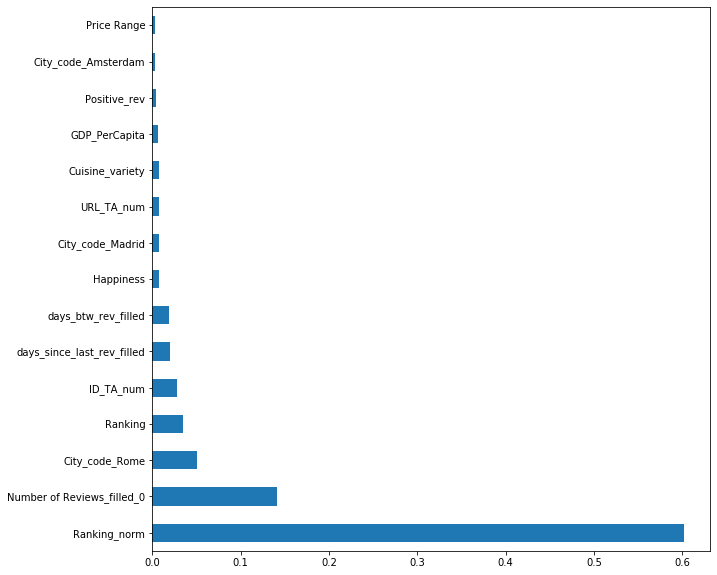

In [167]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

(15.5, -0.5)

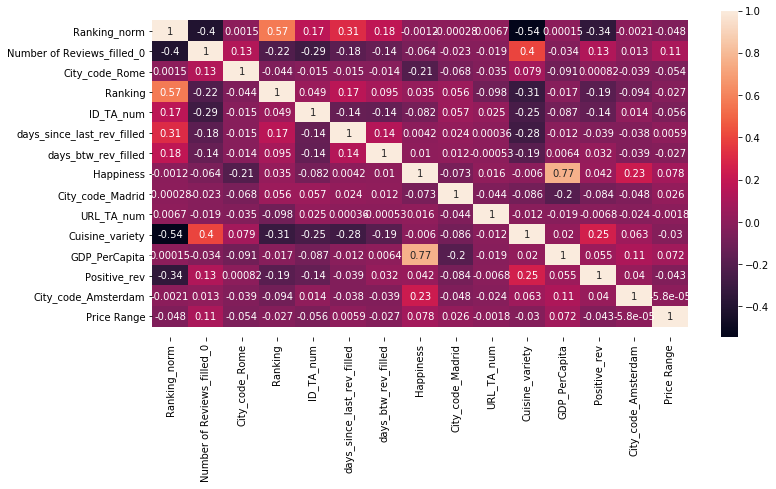

In [168]:
df_temp = df_preproc.loc[data['sample'] == 1, list(feat_importances.nlargest(15).index[0:15])]
plt.rcParams['figure.figsize'] = (12,6)
ax = sns.heatmap(df_temp.corr(), annot=True, fmt='.2g')
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

# Submission
Если все устраевает - готовим Submission на кагл

In [169]:
test_data.sample(10)

,Ranking,Price Range,Rating,Number of Reviews_filled_0,City_code_Amsterdam,City_code_Athens,City_code_Barcelona,City_code_Berlin,City_code_Bratislava,City_code_Brussels,...,Cuisine_Brew Pub,Cuisine_nan,Cuisine_variety,Ranking_norm,no_price_data,days_btw_rev_filled,days_since_last_rev_filled,Positive_rev,ID_TA_num,URL_TA_num
7380,1361.0,3,0.0,107.0,0,0,1,0,0,0,...,0,0,3,-0.741803,0,41.0,181.0,4,1079743,187497
6175,6341.0,1,0.0,66.0,0,0,1,0,0,0,...,0,0,1,0.725060,0,43.0,115.0,3,8830076,187497
6289,1509.0,2,0.0,0.0,0,0,0,0,0,0,...,0,0,1,0.121137,0,88.0,176.0,3,10230176,187309
2853,1985.0,2,0.0,6.0,0,0,0,0,0,0,...,0,1,0,0.513988,0,122.0,219.5,3,1038927,187331
273,10809.0,2,0.0,0.0,0,0,0,0,0,0,...,0,1,0,0.633668,0,86.0,417.0,3,11992842,187147
5593,7644.0,2,0.0,42.0,0,0,0,0,0,0,...,0,1,0,0.853785,0,99.0,218.0,3,4178633,187514
7212,11523.0,2,0.0,41.0,0,0,0,0,0,0,...,0,0,5,0.750564,0,231.0,328.0,3,4053547,187147
7,2330.0,2,0.0,0.0,0,0,0,0,0,0,...,0,1,0,1.088088,0,48.0,134.5,3,8286886,274887
724,7969.0,2,0.0,287.0,0,0,0,0,0,0,...,0,0,2,0.168704,0,17.0,133.0,4,1504635,187147
1668,181.0,2,0.0,1402.0,0,0,0,0,0,0,...,0,0,6,-1.016711,0,10.0,71.0,4,1790459,274887


In [170]:
test_data = test_data.drop(['Rating'], axis=1)

In [171]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [172]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


In [173]:
predict_submission

array([3.02 , 4.16 , 4.135, ..., 3.025, 4.445, 4.23 ])

In [174]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.020
1,id_1,4.160
2,id_2,4.135
3,id_3,4.350
4,id_4,4.465
5,id_5,4.405
6,id_6,1.905
7,id_7,2.385
8,id_8,4.035
9,id_9,4.595
